<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/ProcesoDigitalSen/ProyectoFinalPDS_20201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control de juego por emulador de nintendo utilizando registros de EEG

## 1. Representación utilizando espectro en frecuencia, wavelets, y proyecciones basadas en varianza

## 2. Codificar representación utilizando momentos estadísticos

## 3. Detección de intención de movimiento utilizando Bayes.

## 4. Manipular emulador desde control del teclado utilizando Python.

## 5. Visualizar canales y bandas de frecuencia relevantes para la detección  (interpretabilidad - Por qué?)

Probar en base de datos pública BCI competition 42a

###  1. Representación de señales

In [1]:
# Cargar base de datos
#id del archivo: 1sui-FJI5znNJuQOk0whM6PALI89XfKss
FILEID = "1sui-FJI5znNJuQOk0whM6PALI89XfKss"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir
!pip install mne==0.19

--2020-06-03 14:26:19--  https://docs.google.com/uc?export=download&confirm=03vf&id=1sui-FJI5znNJuQOk0whM6PALI89XfKss
Resolving docs.google.com (docs.google.com)... 74.125.26.101, 74.125.26.100, 74.125.26.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.26.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3o-docs.googleusercontent.com/docs/securesc/hifdk9q5d8prjongp7q77jog06jfnud4/0mkj8cbmsp7gu7k39ek5vvp7df2mqdka/1591194375000/09173029842254050324/13039064888593368827Z/1sui-FJI5znNJuQOk0whM6PALI89XfKss?e=download [following]
--2020-06-03 14:26:19--  https://doc-00-3o-docs.googleusercontent.com/docs/securesc/hifdk9q5d8prjongp7q77jog06jfnud4/0mkj8cbmsp7gu7k39ek5vvp7df2mqdka/1591194375000/09173029842254050324/13039064888593368827Z/1sui-FJI5znNJuQOk0whM6PALI89XfKss?e=download
Resolving doc-00-3o-docs.googleusercontent.com (doc-00-3o-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to

In [35]:
#importar paquetes
#importar carpeta con funciones
import sys
#agregar carpeta con funciones
sys.path.insert(1, './CodesBCIITL')
%matplotlib inline
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, welch, lfilter_zi, stft #, freqz
import numpy as np
from mne.io import read_raw_edf
from mne.decoding import CSP
import pandas as pd
import json as  js #conda install -c jmcmurray json
import warnings
import seaborn as sns
import mne

from numpy import matlib
import os
from matplotlib.animation import FuncAnimation
from ipywidgets import interact

import cv2 

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne import Epochs, pick_types, events_from_annotations

#crear carpeta con resultados
from google.colab import files
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import shutil
from datetime import date, datetime

Carpeta results ya existe


In [36]:
#cargar datos
#Descripcion base de datos
#https://drive.google.com/file/d/1354HvKfp8sMckvN2t3SR9OUo9Z0yE9Uv/view?usp=sharing

sbj = 3 #sujeto facil s03, sujeto dificil s02
name = './CodesBCIITL/data/A0' + str(sbj)
filename_train = name+'T.gdf'
Ch = np.arange(0,22)# lectura canales eeg
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
clases = [769,770] # clases izquierda y derecha -> extender a pies y lengua
vt = [-1.5,3.5] #escoger ventana de analisis : -li:lf desde el estimulo cue # probar con ventana de 1 seg
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
i_muestras, i_clases, raw, Xraw, y, ni,m = leer_bci42a_train_full(filename_train,clases,Ch,vt)
fs = raw.info['sfreq'] #frecuencia de muestreo
print(fs)


Extracting EDF parameters from /content/CodesBCIITL/data/A03T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
250.0


In [37]:
print(Xraw.shape) # epoch (trials) x ch x #muestras
print(y.shape)
np.unique(y)

(137, 22, 500)
(137,)


array([1., 2.])

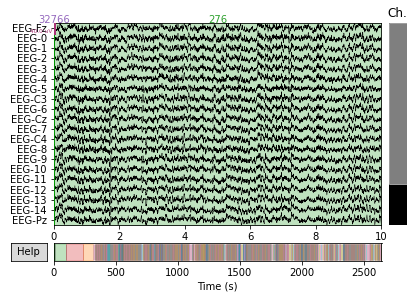

<RawGDF  |  A03T.gdf, n_channels x n_times : 25 x 660530 (2642.1 sec), ~54 kB, data not loaded>


In [38]:
raw.plot() # 137 intentos, 22 canales, 625= 2.5*250: #muestras
#Xraw[0]
print(raw)

# 1.a Representación por FFT

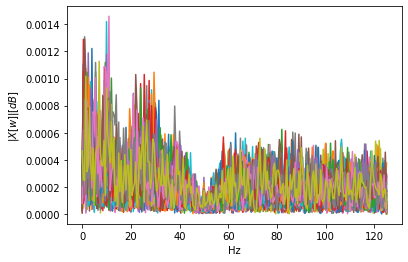

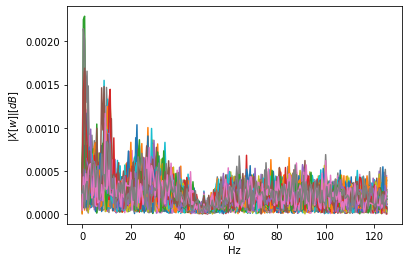

In [39]:
# fft por muestras eje = axis = 2
Xrfft = abs(np.fft.rfft(Xraw,axis=2)) # matriz 1 de atributos segun fft
vf = np.fft.rfftfreq(Xraw.shape[2],1/fs)  # pasar eje x a Hz segun  numero de puntos y periodo muestreo
Xrfft.shape
plt.plot(vf,Xrfft[y==1,11,:].T)
plt.xlabel('Hz')
plt.ylabel('$|X[w]| [dB]$')
plt.show()

plt.plot(vf,Xrfft[y==2,11,:].T)
plt.xlabel('Hz')
plt.ylabel('$|X[w]| [dB]$')
plt.show()

# fs >= 2 fmax
#  fmax <= 0.5 fs

NOTA: nos interesa la información en $\alpha\in[8,12] Hz$; $\beta\in[12,30] Hz$

# 1.b Representación en STFT

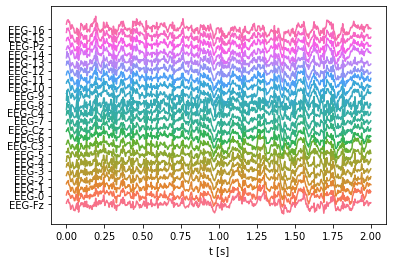

In [60]:
#eeg original trial i
i = 1
plot_eeg(data=Xraw[i],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])
plt.xlabel('t [s]')
plt.savefig('results/EEGOriginal.pdf', dpi=300)


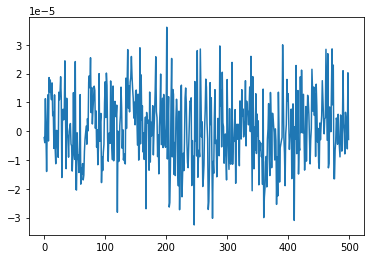

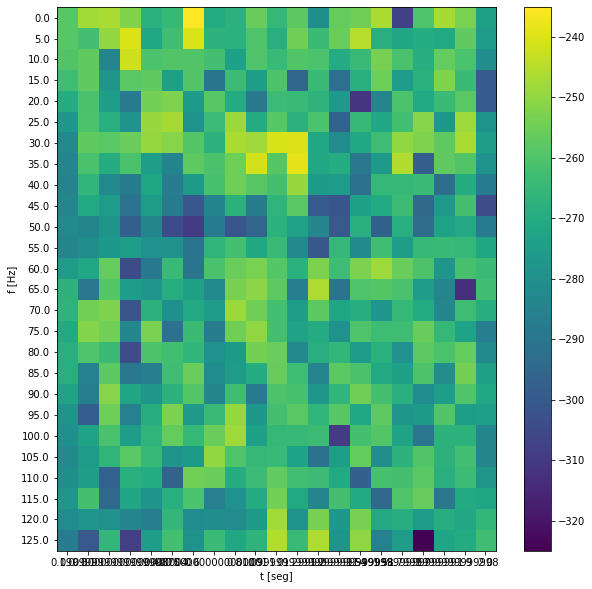

In [61]:
f,t,Xstft = stft(Xraw,fs=fs,nperseg=50,axis=2)
Xstft = abs(Xstft)
trail = 10
chi = 11
plt.plot(Xraw[trail,chi,:])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(20*np.log(Xstft[trail,chi,:,:]))
plt.yticks(ticks=np.arange(len(f)), labels=f)
plt.xticks(ticks=np.arange(len(t)), labels=t)
plt.autoscale()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
plt.colorbar()

In [62]:
print(Xstft.shape) #epocas, Ch, puntos en frecuencia, #ventanas
print(f)
print(t)

(137, 22, 26, 21)
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125.]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]


# 1.c Wavelets - cwt



In [106]:
import pywt 
#w = pywt.Wavelet('db4')
Xcwt,freq =pywt.cwt(Xraw,np.arange(1,50),'cmor',1/fs,axis=2)
Xcwt = abs(np.transpose(Xcwt,[1,2,0,3]))
Xcwt.shape

(137, 22, 49, 500)

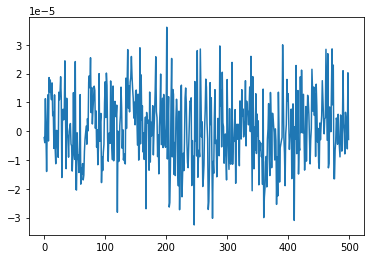

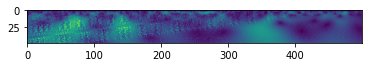

In [113]:
plt.plot(Xraw[trail,chi,:])
plt.show()
plt.imshow(Xcwt[trail,chi])
#plt.yticks(np.arange(len(freq)),freq)
plt.show()


# 1.d PSD

(137, 22, 76)


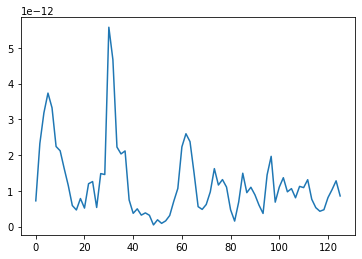

In [132]:
fpsd, Xpsd = welch(Xraw, fs=fs, nperseg=150,axis=2)
print(Xpsd.shape)
fpsd
plt.plot(fpsd,Xpsd[trail,chi,:])
plt.show()

## 2. Codificar representación utilizando momentos estadísticos

# Codificar por momentos alpha y beta: stft, cwt
# fft y psd concatenar los valores del espectro en alpha y beta



In [133]:
def cal_momentos(vec):
  #media, mediana, var, max, min
  return np.array([vec.mean(),np.median(vec),vec.var(),vec.max(),vec.min()])
  
alpha = [8,12]
inda = (fpsd >= alpha[0]) &  (fpsd <= alpha[1])

mm = cal_momentos(Xpsd[trail,chi,inda])
print(Xpsd[trail,chi,inda])
print(mm)
fpsd


[2.23903056e-12 2.12011943e-12 1.62263889e-12]
[1.99392963e-12 2.12011943e-12 7.12850482e-26 2.23903056e-12
 1.62263889e-12]


array([  0.        ,   1.66666667,   3.33333333,   5.        ,
         6.66666667,   8.33333333,  10.        ,  11.66666667,
        13.33333333,  15.        ,  16.66666667,  18.33333333,
        20.        ,  21.66666667,  23.33333333,  25.        ,
        26.66666667,  28.33333333,  30.        ,  31.66666667,
        33.33333333,  35.        ,  36.66666667,  38.33333333,
        40.        ,  41.66666667,  43.33333333,  45.        ,
        46.66666667,  48.33333333,  50.        ,  51.66666667,
        53.33333333,  55.        ,  56.66666667,  58.33333333,
        60.        ,  61.66666667,  63.33333333,  65.        ,
        66.66666667,  68.33333333,  70.        ,  71.66666667,
        73.33333333,  75.        ,  76.66666667,  78.33333333,
        80.        ,  81.66666667,  83.33333333,  85.        ,
        86.66666667,  88.33333333,  90.        ,  91.66666667,
        93.33333333,  95.        ,  96.66666667,  98.33333333,
       100.        , 101.66666667, 103.33333333, 105.  

In [138]:
#Xcwt,freq 
freq.shape
Xcwt.shape
inda = (freq >= 8) & (freq <= 12)
mm = cal_momentos(Xcwt[trail,chi,inda,:].reshape(-1,1))
print(Xcwt[trail,chi,inda,:].reshape(-1,1).shape)
print(mm)


(2500, 1)
[8.85027634e-06 8.08587689e-06 2.05558749e-11 2.86519682e-05
 8.18714582e-08]


In [0]:
def representacion_(Xraw,banda1=[8,12],banda2=[12,30],fs=250,nperseg=100):
  #calculo fourier
  Xrfft = abs(np.fft.rfft(Xraw,axis=2)) # matriz 1 de atributos segun fft
  vf = np.fft.rfftfreq(Xraw.shape[2],1/fs)
  #calculo stft
  f,t,Xstft = stft(Xraw,fs=fs,nperseg=nperseg,axis=2)
  Xstft = abs(Xstft)
  #calculo cwt
  Xcwt,freq =pywt.cwt(Xraw,np.arange(1,50),'cmor',1/fs,axis=2)
  Xcwt = abs(np.transpose(Xcwt,[1,2,0,3]))
  #calculo psd
  fpsd, Xpsd = welch(Xraw, fs=fs, nperseg=nperseg,axis=2)

  ###concatenar por canales e intentos los momentos de stft y cwt en alpha y beta
  ### concatenar por canalues  e intentos los valores de fft y psd en  alpha y beta



  return # Rep [trials,P]; P = #Ch, #bandas=2, #mommentos por cwt y stft, #valores psd y fft
